# 1. Before Using this notebook

## 1a. Install brainlit, and other packages that this notebook uses
## 1b. Write images to s3 using CloudReg
    - e.g. python -m cloudreg.scripts.create_precomputed_volumes --s3_input_paths /mnt/NAS/SmartSPIM_Data/2022_03_02/20220302_14_40_04_8529_destriped_DONE/Ex_561_Em_600_stitched --s3_output_paths  s3://smartspim-precomputed-volumes/2022_03_02/8529/Ch_561_v2  --voxel_size 1.83 1.83 2 --num_procs 24 --resample_iso False
## 1c. Make point annotations in neuroglancer to identify subvolumes for validation (and possible training)
    - instructions: https://neurodata.io/help/neuroglancer-pt-annotations/
## 1d. Update soma_data.py file

## \* Inputs \*

In [1]:
antibody_layer = "Ch_647"
background_layer = "Ch_561"
endogenous_layer = "Ch_488"

In [2]:
from cloudvolume import CloudVolume
from skimage.transform import downscale_local_mean
from skimage import io, measure
import napari
import random
import h5py
from brainlit.preprocessing import removeSmallCCs
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import tables
from napari_animation import AnimationWidget
from tqdm import tqdm
import pickle
from parse_ara import *
import networkx as nx
import seaborn as sns
from statannotations.Annotator import Annotator
import pandas as pd
import brainrender
from skimage.morphology import skeletonize
from soma_data import brain2paths, brain2centers
import os
from util import json_to_points, find_atlas_level_label, fold
import scipy.ndimage as ndi
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import pickle
from cloudreg.scripts.transform_points import NGLink

%gui qt5

In [3]:
for id in brain2paths.keys():
    if "base" in brain2paths[id].keys() and "val_info" in brain2paths[id].keys():
        base = brain2paths[id]["base"]
        if "http" in base:
            print(f"Sample {id}: http in basepath, which may cause write errors")
        for layer in [antibody_layer, background_layer, endogenous_layer]:
            try:
                CloudVolume(base + layer)
            except:
                print(f"Sample {id}: Layer {layer} not found in {base}")

        try:
            url = brain2paths[id]["val_info"]["url"]
            layer = brain2paths[id]["val_info"]["somas_layer"]
            layer = brain2paths[id]["val_info"]["nonsomas_layer"]
            pts = json_to_points(url)[layer]
        except:
            print(f"Sample {id}: Error with val_info")

        if "train_info" in brain2paths[id].keys():
            try:
                url = brain2paths[id]["train_info"]["url"]
                layer = brain2paths[id]["train_info"]["layer"]
                pts = json_to_points(url)[layer]
            except:
                print(f"Sample {id}: Error with train_info")
    else:
        print(f"Sample {id}: Does not conform to desired format")

Sample 8557: Does not conform to desired format
Sample 8555: Does not conform to desired format
Sample 8607: Does not conform to desired format
Sample 8468: Does not conform to desired format
Sample 8529: Does not conform to desired format
Sample 8477: Does not conform to desired format
Sample 8531: Does not conform to desired format
Sample 8608: Error with val_info
Sample 8446: Does not conform to desired format
Sample 8454: Does not conform to desired format
Sample 887: Does not conform to desired format
Sample 878: Does not conform to desired format


# 2. Download benchmark data

## \*Inputs\*

In [ ]:
brain = "8608"  # brain ID
axon_data_dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/"  # path to directory where training/validation data should be stored
dataset_to_save = "val"  # train or val

In [ ]:
# Useful variables
base_dir = axon_data_dir + "brain" + brain + "/" + dataset_to_save + "/"

if brain not in brain2paths.keys():
    raise ValueError(f"brain {brain} not an entry in brain2paths in axon_data.py file")

if f"{dataset_to_save}_info" not in brain2paths[
    brain
].keys() or dataset_to_save not in ["train", "val"]:
    raise ValueError(f"{dataset_to_save}_info not in brain2paths[{brain}].keys()")

## Setup paths

In [ ]:
if "val_info" in brain2paths[brain].keys():
    if dataset_to_save == "val":
        url = brain2paths[brain]["val_info"]["url"]
        l_dict = json_to_points(url)
        soma_centers = l_dict[brain2paths[brain]["val_info"]["somas_layer"]]
        nonsoma_centers = l_dict[brain2paths[brain]["val_info"]["nonsomas_layer"]]
    elif dataset_to_save == "train":
        raise NotImplementedError()
elif "vizlink" in brain2paths[brain]:
    url = brain2paths[brain]["vizlink"]
    l_dict = json_to_points(url)
    if dataset_to_save == "val":
        soma_centers = l_dict["soma_val"]
        nonsoma_centers = l_dict["nonsoma_val"]
    elif dataset_to_save == "train":
        soma_centers = l_dict["soma_train"]
        nonsoma_centers = l_dict["nonsoma_train"]
    elif dataset_to_save == "train-obj":
        soma_centers = l_dict["soma_train_obj"]
        nonsoma_centers = l_dict["nonsoma_train_obj"]
elif brain in brain2centers.keys():
    soma_centers = brain2centers[brain][0][0]
    nonsoma_centers = brain2centers[brain][1][0]
else:
    print("No training/validation points")

print(f"{len(soma_centers)} soma centers")
print(f"{len(nonsoma_centers)} nonsoma centers")

mip = 0
if "base" in brain2paths[brain].keys():
    base_dir_s3 = brain2paths[brain]["base"]
    dir = base_dir_s3 + antibody_layer
    vol_fg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
    print(f"fg shape: {vol_fg.shape} at {vol_fg.resolution}")
    dir = base_dir_s3 + background_layer
    vol_bg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
    print(f"bg shape: {vol_bg.shape} at {vol_bg.resolution}")
    dir = base_dir_s3 + endogenous_layer
    vol_endo = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
    print(f"endo shape: {vol_endo.shape} at {vol_endo.resolution}")
else:
    dir = brain2paths[brain]["ab"]
    vol_fg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
    print(f"fg shape: {vol_fg.shape} at {vol_fg.resolution}")
    dir = brain2paths[brain]["bg"]
    vol_bg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
    print(f"bg shape: {vol_bg.shape} at {vol_bg.resolution}")
    dir = brain2paths[brain]["endo"]
    vol_endo = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
    print(f"endo shape: {vol_endo.shape} at {vol_endo.resolution}")

## Download data

In [ ]:
isExist = os.path.exists(base_dir)
if not isExist:
    print(f"Creating directory: {base_dir}")
    os.makedirs(base_dir)
else:
    print(f"Downloaded data will be stored in {base_dir}")

for type in ["pos", "neg"]:
    for i, center in enumerate(tqdm(soma_centers, desc="Saving positive samples")):
        image_fg = vol_fg[
            center[0] - 24 : center[0] + 25,
            center[1] - 24 : center[1] + 25,
            center[2] - 24 : center[2] + 25,
        ]
        image_fg = image_fg[:, :, :, 0]
        image_bg = vol_bg[
            center[0] - 24 : center[0] + 25,
            center[1] - 24 : center[1] + 25,
            center[2] - 24 : center[2] + 25,
        ]
        image_bg = image_bg[:, :, :, 0]
        image_endo = vol_endo[
            center[0] - 24 : center[0] + 25,
            center[1] - 24 : center[1] + 25,
            center[2] - 24 : center[2] + 25,
        ]
        image_endo = image_endo[:, :, :, 0]

        image = np.squeeze(np.stack([image_fg, image_bg, image_endo], axis=0))

        fname = (
            base_dir + f"{int(center[0])}_{int(center[1])}_{int(center[2])}_{type}.h5"
        )
        with h5py.File(fname, "w") as f:
            dset = f.create_dataset("image_3channel", data=image)

# 3. View downloaded data (optional)

## \*Inputs\*

In [ ]:
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainr2/val/891_4202_1717_pos.h5"  # path to file for viewing
scale = [1.8, 1.8, 2]  # voxel size in microns

In [ ]:
with h5py.File(fname, "r") as f:
    pred = f.get("image_3channel")
    image_fg = pred[0, :, :, :]
    image_bg = pred[1, :, :, :]
    image_endo = pred[2, :, :, :]

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_fg, scale=scale)
viewer.add_image(image_bg, scale=scale)
viewer.add_image(image_endo, scale=scale)
viewer.scale_bar.visible = True
viewer.scale_bar.unit = "um"

# 4. Apply ilastik to validation data

You will need to do two things:
- apply soma segmentation model to the downloaded data. Results should be located in the same directory at the subvolumes, with the addition of "_Probabilities" appended to the file names
- identify files that have two somas in variable below. Since voxel coordinates are likely to be unique across samples, the file names below do not include sample IDs.

In [ ]:
doubles = [
    "3972_1636_1575_pos_Probabilities.h5",
    "2867_4336_1296_pos_Probabilities.h5",
    "2607_1845_1309_pos_Probabilities.h5",
    "2101_3397_1747_pos_Probabilities.h5",
    "2011_3452_1911_pos_Probabilities.h5",
    "2113_3353_1727_pos_Probabilities.h5",
    "1968_3472_1784_pos_Probabilities.h5",
]  # 8446

# 5. Check Results

## Validation

In [ ]:
recalls = []
precisions = []

files_dir = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brain{brain}/val/"
onlyfiles = [
    f for f in os.listdir(files_dir) if os.path.isfile(os.path.join(files_dir, f))
]
test_files = [f for f in onlyfiles if "Probabilities" in f]  # "probabilities"
print(test_files)

size_thresh = 500

thresholds = list(np.arange(0.0, 1.0, 0.02))

for threshold in thresholds:
    tot_pos = 0
    true_pos = 0
    false_pos = 0
    for filename in tqdm(test_files, disable=True):
        if filename in doubles:
            newpos = 2
        else:
            newpos = 1

        fname = files_dir + filename
        f = h5py.File(fname, "r")
        pred = f.get("exported_data")
        pred = pred[0, :, :, :]
        mask = pred > threshold
        labels = measure.label(mask)
        props = measure.regionprops(labels)

        if "pos" in filename:
            num_detected = 0
            tot_pos += newpos
            for prop in props:
                if prop["area"] > size_thresh:
                    if num_detected < newpos:
                        true_pos += 1
                        num_detected += 1
                    else:
                        false_pos += 1
        elif "neg" in filename:
            for prop in props:
                if prop["area"] > size_thresh:
                    false_pos += 1

    recall = true_pos / tot_pos
    recalls.append(recall)
    if true_pos + false_pos == 0:
        precision = 0
    else:
        precision = true_pos / (true_pos + false_pos)
    precisions.append(precision)
    if precision == 0 and recall == 0:
        fscore = 0
    else:
        fscore = 2 * precision * recall / (precision + recall)
    print(
        f"threshold: {threshold}: precision: {precision}, recall: {recall}, f-score: {fscore} for {tot_pos} positive samples in {len(test_files)} images"
    )

fscores = [
    2 * precision * recall / (precision + recall)
    if (precision != 0 and recall != 0)
    else 0
    for precision, recall in zip(precisions, recalls)
]
dict = {
    "Recall": recalls,
    "Precision": precisions,
    "F-score": fscores,
    "Threshold": thresholds,
}
df = pd.DataFrame(dict)
max_fscore = df["F-score"].max()
best_threshold = float(df.loc[df["F-score"] == max_fscore]["Threshold"].iloc[0])
best_rec = float(df.loc[df["F-score"] == max_fscore]["Recall"].iloc[0])
best_prec = float(df.loc[df["F-score"] == max_fscore]["Precision"].iloc[0])
sns.set(font_scale=2)

plt.figure(figsize=(8, 8))
sns.lineplot(data=df, x="Recall", y="Precision", estimator=np.amax, ci=False)
plt.scatter(
    best_rec,
    best_prec,
    c="r",
    label=f"Max f-score: {max_fscore:.2f} thresh:{best_threshold:.2f}",
)
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.title(f"Brain {brain} Validation: {tot_pos}+ {len(nonsoma_centers)}-")
plt.legend()

## If results above are not adequate, improve model and try again

In my case, I identify more subvolumes from the sample at hand using the same process as for validation data, and add it as training data to the model and retrain.

## Examine best threshold

In [ ]:
for filename in tqdm(test_files, disable=True):
    print(f"*************File: {filename}*********")
    if filename in doubles:
        newpos = 2
    else:
        newpos = 1

    im_fname = files_dir + filename[:-17] + ".h5"
    fname = files_dir + filename
    f = h5py.File(fname, "r")
    pred = f.get("exported_data")
    pred = pred[0, :, :, :]
    mask = pred > best_threshold
    labels = measure.label(mask)
    props = measure.regionprops(labels)

    if "pos" in filename:
        num_detected = 0
        tot_pos += newpos
        for prop in props:
            area = prop["area"]
            if area > size_thresh:
                print(f"area of detected object: {area}")
                if num_detected < newpos:
                    true_pos += 1
                    num_detected += 1
                else:
                    print(f"Soma false positive Area: {area}")
                    f = h5py.File(im_fname, "r")
                    im = f.get("image_3channel")
                    viewer = napari.Viewer(ndisplay=3)
                    viewer.add_image(im[0, :, :, :], name=filename)
                    viewer.add_image(im[1, :, :, :], name="bg")
                    viewer.add_image(im[2, :, :, :], name="endo")
                    viewer.add_labels(mask)
                    viewer.add_labels(
                        labels == prop["label"],
                        name=f"soma false positive area: {area}",
                    )
                    false_pos += 1
        if num_detected == 0:
            print(f"Soma false negative")
            f = h5py.File(im_fname, "r")
            im = f.get("image_3channel")
            viewer = napari.Viewer(ndisplay=3)
            viewer.add_image(im[0, :, :, :], name=filename)
            viewer.add_image(im[1, :, :, :], name="bg")
            viewer.add_image(im[2, :, :, :], name="endo")
            viewer.add_labels(mask, name="Soma false negative")
    elif "neg" in filename:
        for prop in props:
            area = prop["area"]
            if area > size_thresh:
                print(f"Nonsoma false positive Area: {area}")
                f = h5py.File(im_fname, "r")
                im = f.get("image_3channel")
                viewer = napari.Viewer(ndisplay=3)
                viewer.add_image(im[0, :, :, :], name=filename)
                viewer.add_image(im[1, :, :, :], name="bg")
                viewer.add_image(im[2, :, :, :], name="endo")
                viewer.add_labels(mask)
                viewer.add_labels(
                    labels == prop["label"], name=f"nonsoma false positive area: {area}"
                )
                false_pos += 1

## Paper figure for all validation

In [ ]:
brains = [
    "8607",
    "8606",
    "8477",
    "8531",
    "8608",
    "8529",
    "8557",
    "8555",
    "8446",
    "8454",
    "887",
]

recalls = []
precisions = []
brain_ids = []

best_precisions = []
best_recalls = []
best_fscores = {}

for brain_id in tqdm(brains, desc="Computing validation..."):

    if brain_id == "8557":
        brain_name = "r1"
    elif brain_id == "8555":
        brain_name = "r2"
    else:
        brain_name = brain_id

    files_dir = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brain{brain_name}/val/"
    onlyfiles = [
        f for f in os.listdir(files_dir) if os.path.isfile(os.path.join(files_dir, f))
    ]
    test_files = [f for f in onlyfiles if "Probabilities" in f]

    best_fscore = 0

    size_thresh = 500

    thresholds = list(np.arange(0.0, 1.0, 0.02))

    for threshold in thresholds:
        tot_pos = 0
        true_pos = 0
        false_pos = 0
        for filename in tqdm(test_files, disable=True):
            if filename in doubles:
                newpos = 2
            else:
                newpos = 1

            fname = files_dir + filename
            f = h5py.File(fname, "r")
            pred = f.get("exported_data")
            pred = pred[0, :, :, :]
            mask = pred > threshold
            labels = measure.label(mask)
            props = measure.regionprops(labels)

            if "pos" in filename:
                num_detected = 0
                tot_pos += newpos
                for prop in props:
                    if prop["area"] > size_thresh:
                        if num_detected < newpos:
                            true_pos += 1
                            num_detected += 1
                        else:
                            false_pos += 1
            elif "neg" in filename:
                for prop in props:
                    if prop["area"] > size_thresh:
                        false_pos += 1

        recall = true_pos / tot_pos
        recalls.append(recall)
        if true_pos + false_pos == 0:
            precision = 1
        else:
            precision = true_pos / (true_pos + false_pos)

        precisions.append(precision)
        if precision == 0 and recall == 0:
            fscore = 0
        else:
            fscore = 2 * precision * recall / (precision + recall)

        if fscore > best_fscore:
            best_fscore = fscore
            best_prec = precision
            best_recall = recall

        brain_ids.append(brain_id)
    best_fscores[brain_id] = best_fscore
    best_precisions.append(best_prec)
    best_recalls.append(best_recall)


for i, brain_id in enumerate(brain_ids):
    brain_ids[i] = brain_id + f" - Max F-score: {best_fscores[brain_id]:.2f}"

data = {"Sample": brain_ids, "Recall": recalls, "Precision": precisions}
df = pd.DataFrame(data=data)

sns.set(rc={"figure.figsize": (10, 7)})
sns.set(font_scale=2)
sns.lineplot(data=df, x="Recall", y="Precision", hue="Sample", estimator="max", ci=None)
sns.scatterplot(x=best_recalls, y=best_precisions)

# 6. Make Annotation layers

## Transformed layers

In [ ]:
atlas_vol = CloudVolume(
    "precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017"
)
for layer in [
    antibody_layer,
    background_layer,
]:  # axon_mask is transformed into an image because nearest interpolation doesnt work well after downsampling

    layer_path = brain2paths[brain]["base"] + layer + "_transformed"
    info = CloudVolume.create_new_info(
        num_channels=1,
        layer_type="image",
        data_type="uint16",  # Channel images might be 'uint8'
        encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
        resolution=atlas_vol.resolution,  # Voxel scaling, units are in nanometers
        voxel_offset=atlas_vol.voxel_offset,
        chunk_size=[32, 32, 32],  # units are voxels
        volume_size=atlas_vol.volume_size,  # e.g. a cubic millimeter dataset
    )
    vol_mask = CloudVolume(layer_path, info=info)
    vol_mask.commit_info()

# 7. Apply ilastik to whole image

e.g. using `soma_detect_image.py`

# 8. Register volume using CloudReg

## 8a. You need to find an initial affine alignment using cloudreg.scripts.registration.get_affine_matrix. For example: 

```
from cloudreg.scripts.registration import get_affine_matrix
get_affine_matrix([1,1,1], [15,0,0], "PIR", "RAI", 1.15, "precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017")
```

## 8b. Run registration using cloudreg.scripts.registration. For example:

```
python -m cloudreg.scripts.registration -input_s3_path precomputed://s3://smartspim-precomputed-volumes/2022_11_01/8790/Ch_561 --output_s3_path precomputed://s3://smartspim-precomputed-volumes/2022_11_01/8790/atlas_to_target --atlas_s3_path https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_50um/average_50um --parcellation_s3_path https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017 --atlas_orientation PIR -orientation RAI --rotation 0 0 0 --translation 0 0 0 --fixed_scale 1.2 -log_s3_path precomputed://s3://smartspim-precomputed-volumes/2022_11_01/8790/atlas_to_target --missing_data_correction True --grid_correction False --bias_correction True --regularization 5000.0 --iterations 3000 --registration_resolution 100
```

# 9. Collect region based results

Use `soma_collect_results.py`

# 10. Transform soma detection coordinates to atlas space using CloudReg

```
python -m cloudreg.scripts.transform_points --target_viz_link https://viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=6ti276yAxXF_Rw --atlas_viz_link https://ara.viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=HvyNDGaPsd1wyg --affine_path /mnt/NAS/Neuroglancer\ Data/  --velocity_path /mnt/NAS/Neuroglancer\ Data/  --transformation_direction atlas
```

# 11. View coronal maps

## \*Inputs\*

In [ ]:
atlas_level = 5  # level of ARA to partition the figures

colors = {
    "tph2 vglut3": "blue",
    "tph2 gad2": "red",
    "gad2 vgat": "green",
}  # colors for different genotypes
symbols = ["o", "+", "^", "vbar"]  # symbols for different samples within genotype group

atlas_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/ara/ara_10um.tif"  # Path to 10um atlas parcellation
# atlas can be downloaded from here: https://neurodata.io/data/allen_atlas/
fold_on = False  # Whether to fold results over midline

## Setup Atlas

In [ ]:
import json
from parse_ara import *
import networkx as nx
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyvis.network import Network

# create vikram object
f = json.load(
    open(
        "ara_structure_ontology.json",
        "r",
    )
)

tree = build_tree(f)
stack = [tree]

# create nx graph
queue = [tree]
cur_level = -1
counter = 0
G = nx.DiGraph()
max_level = 0


while len(queue) > 0:
    node = queue.pop(0)
    if node.level > max_level:
        max_level = node.level
    G.add_node(
        node.id,
        level=node.level,
        st_level=node.st_level,
        name=node.name,
        acronym=node.acronym,
        label=str(node.st_level) + ") " + node.name,
    )
    if node.parent_id is not None:
        G.add_edge(node.parent_id, node.id)

    queue += node.children

In [ ]:
atlas_level_nodes = []

print(f"Regions in selected atlas level ({atlas_level})")
for node in G.nodes:
    if G.nodes[node]["st_level"] == atlas_level:
        atlas_level_nodes.append(node)
        print(f"{node}: {G.nodes[node]['name']}")

In [ ]:
parcellation = CloudVolume(
    "precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017"
)
atlas = io.imread(atlas_path)


atlas_points = {}

for key in brain2paths.keys():
    if "somas_atlas_url" in brain2paths[key].keys():
        viz_link = brain2paths[key]["somas_atlas_url"]
        viz_link = NGLink(viz_link.split("json_url=")[-1])
        ngl_json = viz_link._json
        for layer in ngl_json["layers"]:
            if layer["type"] == "annotation":
                points = []
                for annot in layer["annotations"]:
                    points.append(annot["point"])

                atlas_points[key] = np.array(points)
                print(
                    f'Brain {key}: Collecting atlas space soma points from layer: {layer["name"]}'
                )
                break

In [ ]:
new_labels = {}
for z in np.arange(100, 1300, 500):
    slice = atlas[z, :, :]
    newslice = np.copy(slice)
    for label in tqdm(np.unique(slice), desc=f"Relabeling in z={z}"):
        atlas_level_label = find_atlas_level_label(
            label, atlas_level_nodes, atlas_level, G
        )
        newslice[slice == label] = atlas_level_label
        if atlas_level_label not in new_labels.keys():
            if atlas_level_label in G.nodes:
                name = G.nodes[atlas_level_label]["name"]
            else:
                name = "??"
            new_labels[atlas_level_label] = name

    labels = measure.label(newslice)
    borders = 0 * labels
    for label in tqdm(np.unique(labels), desc=f"Processing labels in z={z}"):
        if label != 0:
            mask = np.array(labels == label, dtype="int")
            erode = np.array(ndi.binary_erosion(mask))
            outline = mask - erode
            borders += outline

    if fold_on:
        half_width = np.round(borders.shape[1] / 2).astype(int)
        borders = borders[:, :half_width]
        newslice = newslice[:, :half_width]

    v = napari.Viewer()
    v.add_labels(newslice, scale=[10, 10])
    v.add_image(borders, scale=[10, 10], name=f"z={z}")

    gtype_counts = {"tph2 vglut3": 0, "tph2 gad2": 0, "gad2 vgat": 0}
    for key in tqdm(atlas_points.keys(), desc=f"Processing brains in z={z}"):
        ra = atlas_points[key]
        gtype = brain2paths[key]["genotype"]

        ra = atlas_points[key]
        points = ra[(ra[:, 0] < z + 10) & (ra[:, 0] > z - 10)]

        # only select points that fall on an ROI
        fg_points = []
        for point in points:
            im_coord = [int(point[1]), int(point[2])]

            if (
                im_coord[0] in range(0, newslice.shape[0])
                and im_coord[1] in range(0, newslice.shape[1])
                and newslice[im_coord[0], im_coord[1]] != 0
            ):
                if fold_on and im_coord[1] >= half_width:
                    im_coord[1] = 2 * half_width - im_coord[1]

                fg_points.append([im_coord[0], im_coord[1]])

        v.add_points(
            fg_points,
            symbol=symbols[gtype_counts[gtype]],
            face_color=colors[gtype],
            size=10,
            name=f"{key}: {gtype}",
            scale=[10, 10],
        )
        gtype_counts[gtype] = gtype_counts[gtype] + 1

    v.scale_bar.unit = "um"
    v.scale_bar.visible = True

# 12. Display bar charts

## \*Inputs\*

In [4]:
wholebrain_results_dir = ""  #

brains = {
    "8557": "tph2 vglut3",
    "8555": "tph2 vglut3",
    "8607": "tph2 gad2",
    "8606": "tph2 gad2",
    "8477": "gad2/vgat",
    "8531": "gad2/vgat",
    "8608": "tph2 gad2",
    "8529": "gad2/vgat",
    "8454": "gad2/vgat",
    "8446": "gad2/vgat",
}  # dictionary with key as sample ID and value as subtype for results to be shown

regions = [
    688,  # cerebral cortex
    698,  # olfactory areas
    1089,  # hippocampal formation
    # 583, # claustrum
    477,  # striatum
    # 803, # pallidum
    351,  # bed nuclei of stria terminalis
    # 703, #cortical subplate
    1097,  # hypothalamus
    549,  # thalamus
    186,  # lateral habenula
    519,  # cerebellar nuclei
    313,  # midbrain
    1065,  # hindbrain
]  # allen atlas region IDs to be shown
# see: https://connectivity.brain-map.org/projection/experiment/480074702?imageId=480075280&initImage=TWO_PHOTON&x=17028&y=11704&z=3

composite_regions = {
    "Amygdalar Nuclei": [131, 295, 319, 780]
}  # Custom composite allen regions where key is region name and value is list of allen regions

level = "coarse"  # coarse or fine, dictates whether the regions specified above will be shown (coarse), or their subregions (fine)

if level not in ["coarse", "fine"]:
    raise ValueError(f"level must be coarse or fine, not {level}")

## Setup data

In [5]:
counts = {}
for gene in set(brains.values()):
    count = 0
    for brain in brains.keys():
        if brains[brain] == gene:
            count += 1
    counts[gene] = count


quantification_dicts = {}

for brain in brains.keys():
    path = (
        "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/wholebrain_results/quantification_dict_"
        + brain
        + ".pickle"
    )
    with open(path, "rb") as f:
        quantification_dict = pickle.load(f)

    quantification_dicts[brain] = quantification_dict

In [6]:
f = json.load(
    open(
        "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/lsm_analysis/ara_structure_ontology.json",
        "r",
    )
)

tree = build_tree(f)
stack = [tree]

In [7]:
queue = [tree]
cur_level = -1
counter = 0
G = nx.DiGraph()
max_level = 0

# Initialize nodes

while len(queue) > 0:
    node = queue.pop(0)
    if node.level > max_level:
        max_level = node.level
    G.add_node(
        node.id,
        level=node.level,
        st_level=node.st_level,
        name=node.name,
        acronym=node.acronym,
        label=str(node.st_level) + ") " + node.name,
    )
    for brain in quantification_dicts.keys():
        G.nodes[node.id][brain] = 0
    if node.parent_id is not None:
        G.add_edge(node.parent_id, node.id)

    queue += node.children

# add data
i_test = 0
print(f"Max level: {max_level}")
print(G.nodes[997][list(quantification_dicts.keys())[i_test]])
for brain, quantification_dict in quantification_dicts.items():
    for key in quantification_dict.keys():
        if key in G.nodes:
            G.nodes[key][brain] = G.nodes[key][brain] + quantification_dict[key]

print(G.nodes[997][list(quantification_dicts.keys())[i_test]])

# add child data to parent data
for brain in quantification_dicts.keys():
    for lvl in range(max_level, 0, -1):
        for node in G.nodes:
            if G.nodes[node]["level"] == lvl:
                parent = list(G.in_edges(node))[0][0]
                G.nodes[parent][brain] = G.nodes[parent][brain] + G.nodes[node][brain]
print(G.nodes[997][list(quantification_dicts.keys())[i_test]])

Max level: 10
0
7
3853


In [8]:
totals = {}

for brain in quantification_dicts.keys():
    total = 0
    for node in G.nodes:
        total += G.nodes[node][brain]
    totals[brain] = total

somas = []
somas_norm = []
somas_pct = []
gene = []
subregion_name = []
region_name = []
brain_ids = []
for region in regions:
    print(f"Populating: " + G.nodes[region]["name"])
    # choose level here
    if level == "fine":
        children = list(G.successors(region))
    elif level == "coarse":
        children = [region]
    else:
        raise ValueError(f"level must be coarse or fine, not {level}")

    for child in children:
        for brain in quantification_dicts.keys():
            soma_count = G.nodes[child][brain]
            drn_somas = G.nodes[872][brain]

            somas.append(soma_count)
            if drn_somas != 0:
                somas_norm.append(soma_count / drn_somas)
            else:
                print(f"Warning: brain {brain} has no inputs from DRN")
                somas_norm.append(0)
            somas_pct.append(G.nodes[child][brain] / totals[brain] * 100)

            gene.append(brains[brain] + f" (n={counts[brains[brain]]})")
            subregion_name.append(G.nodes[child]["name"])
            region_name.append(G.nodes[region]["name"])
            brain_ids.append(brain)

for region_component_name in composite_regions.keys():
    print(f"Populating: " + region_component_name)
    region_components = composite_regions[region_component_name]
    for brain in quantification_dicts.keys():

        soma_count = 0

        for region_component in region_components:
            soma_count += G.nodes[region_component][brain]

        drn_somas = G.nodes[872][brain]

        somas.append(soma_count)
        if drn_somas != 0:
            somas_norm.append(soma_count / drn_somas)
        else:
            print(f"Warning: brain {brain} has no inputs from DRN")
            somas_norm.append(0)
        somas_pct.append(G.nodes[child][brain] / totals[brain] * 100)

        gene.append(brains[brain] + f" (n={counts[brains[brain]]})")
        subregion_name.append(region_component_name)
        region_name.append(region_component_name)
        brain_ids.append(brain)

d = {
    "Somas (#)": somas,
    "Normalized Somas": somas_norm,
    "Percent of Total Somas (%)": somas_pct,
    "Gene": gene,
    "Subregion": subregion_name,
    "Region": region_name,
    "Brain ID": brain_ids,
}
df = pd.DataFrame(data=d)

Populating: Cerebral cortex
Populating: Olfactory areas
Populating: Hippocampal formation
Populating: Striatum
Populating: Bed nuclei of the stria terminalis
Populating: Hypothalamus
Populating: Thalamus
Populating: Lateral habenula
Populating: Cerebellar nuclei
Populating: Midbrain
Populating: Hindbrain
Populating: Amygdalar Nuclei


## Make bar chart

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Hippocampal formation_tph2 vglut3 (n=2) vs. Hippocampal formation_tph2 gad2 (n=3): t-test independent samples with Benjamini-Yekutieli correction, P_val:7.081e-01 t=4.119e-01
Striatum_tph2 vglut3 (n=2) vs. Striatum_tph2 gad2 (n=3): t-test independent samples with Benjamini-Yekutieli correction, P_val:4.120e-01 t=9.505e-01
Bed nuclei of the stria terminalis_tph2 vglut3 (n=2) vs. Bed nuclei of the stria terminalis_tph2 gad2 (n=3): t-test independent samples with Benjamini-Yekutieli correction, P_val:4.928e-01 t=7.789e-01
Hypothalamus_tph2 vglut3 (n=2) vs. Hypothalamus_tph2 gad2 (n=3): t-test independent samples with Benjamini-Yekutieli correction, P_val:6.671e-01 t=4.752e-01
Thalamus_tph2 vglut3 (n=2) vs. Thalamus_tph2 gad2 (n=3): t-test independent samples with Benjamini-Yekutieli correction, P_val:7.833e-01 

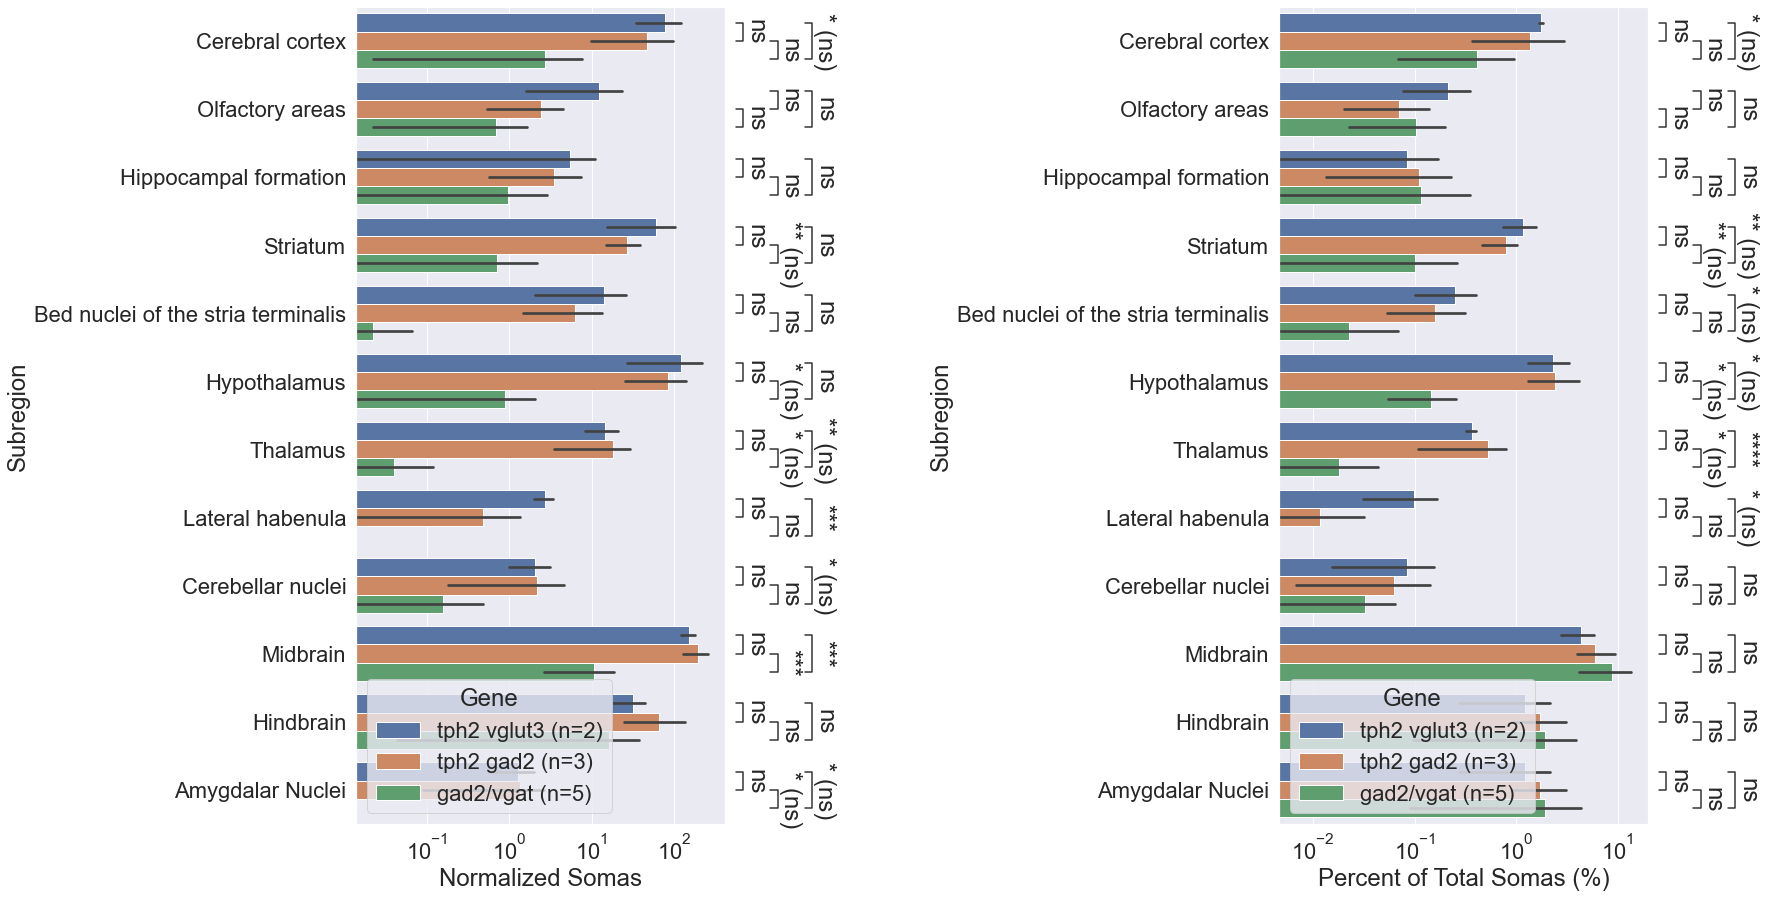

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(26, 13))
sns.set(font_scale=2)

test = "Mann-Whitney"
test = "t-test_ind"
correction = "fdr_by"

# soma counts
fig_args = {
    "y": "Normalized Somas",
    "x": "Subregion",
    "hue": "Gene",
    "data": df,
}
pairs = []
unq_subregions = []
for subregion in subregion_name:
    if subregion not in unq_subregions:
        unq_subregions.append(subregion)


genes = df["Gene"].unique()
gene_pairs = [(a, b) for idx, a in enumerate(genes) for b in genes[idx + 1 :]]

for gene_pair in gene_pairs:
    for subregion in unq_subregions:
        pairs.append(
            (
                (subregion, gene_pair[0]),
                (subregion, gene_pair[1]),
            )
        )


annotator = Annotator(axes[0], pairs, **fig_args)
fig_args = {
    "x": "Normalized Somas",
    "y": "Subregion",
    "hue": "Gene",
    "data": df,
}


sns.set(font_scale=2)
bplot = sns.barplot(ax=axes[0], orient="h", **fig_args)
bplot.set_xscale("log")

annotator.configure(
    test=test, text_format="star", loc="outside", comparisons_correction=correction
)
annotator.new_plot(bplot, orient="h", plot="barplot", **fig_args)
annotator.apply_and_annotate()

# distribution
fig_args = {
    "y": "Percent of Total Somas (%)",
    "x": "Subregion",
    "hue": "Gene",
    "data": df,
}
pairs = []
unq_subregions = []
for subregion in subregion_name:
    if subregion not in unq_subregions:
        unq_subregions.append(subregion)


for gene_pair in gene_pairs:
    for subregion in unq_subregions:
        pairs.append(
            (
                (subregion, gene_pair[0]),
                (subregion, gene_pair[1]),
            )
        )


annotator = Annotator(axes[1], pairs, **fig_args)
fig_args = {
    "x": "Percent of Total Somas (%)",
    "y": "Subregion",
    "hue": "Gene",
    "data": df,
}

bplot = sns.barplot(ax=axes[1], orient="h", **fig_args)
bplot.set_xscale("log")

annotator.configure(
    test=test, text_format="star", loc="outside", comparisons_correction=correction
)
annotator.new_plot(bplot, orient="h", plot="barplot", **fig_args)
annotator.apply_and_annotate()

fig.tight_layout()

## Compare distributions with PCA

In [ ]:
X = []
brain_ids = []
genotypes = []

for i, brain in enumerate(brains):
    print(brain)
    region_order = list(df.loc[df["Brain ID"] == brain]["Region"])

    if i == 0:
        standard_region_order = region_order
    elif standard_region_order != region_order:
        raise ValueError(f"Different region order for brain {brain}")

    distrib = list(df.loc[df["Brain ID"] == brain]["Percent of Total Somas (%)"])
    X.append(distrib)

    brain_ids.append(brain)
    genotypes.append(brains[brain])

X = np.array(X)

pca = PCA(n_components=2)
X_2 = pca.fit_transform(X)

df_pca = {
    "PC 1": X_2[:, 0],
    "PC 2": X_2[:, 1],
    "Genotype": genotypes,
    "Brain ID": brain_ids,
}
df_pca = pd.DataFrame(data=df_pca)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(data=df_pca, x="PC 1", y="PC 2", hue="Genotype", ax=ax)


for i in range(df_pca.shape[0]):
    plt.text(
        x=df_pca["PC 1"][i] + 0.03,
        y=df_pca["PC 2"][i] + 0.03,
        s=df_pca["Brain ID"][i],
        fontdict=dict(color="black", size=20),
    )

plt.title(
    f"Input Distribution PCA with Explained Variance: {pca.explained_variance_ratio_}"
)